<a href="https://colab.research.google.com/github/SbZhan/PyElastica/blob/master/FitParaFunc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Header
from matplotlib import pyplot as plt
%matplotlib inline 
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.font_manager as fm

from google.colab import drive
drive.mount('/content/drive')

dblue = '#132d4b'
orange = '#e84a27'
gray = '#707372'
lorange = '#e3A535'
yellow = '#fee951'
blue = '#016fb9'
teal = '#27cff9'

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize

plt.rc('lines',lw=2, markersize=5.0)
plt.rc('figure', dpi=300, figsize=[3,9/4])

# Import the font 
path = 'drive/MyDrive/FitParameterFunction/Font/times new roman.ttf'
fm.fontManager.addfont(path)
props = fm.FontProperties(fname=path)
# Add the font to our runtime configuration
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = props.get_name()
plt.rcParams['mathtext.fontset'] = 'dejavuserif' # sets the math font as a serif font as well

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Import data 
data = pd.read_csv('drive/MyDrive/FitParameterFunction/RawData/20221122_Twisting_10to1_thickness.csv')

preload = 0.001 * 9.8 * data.loc[:,"Fpre"] # Preload applied on the legs
tipAngle = 0.5 * (np.pi/180) * data.loc[:,"Max tip angle"] # Half angle when the twisting occurs
b = 0.001  * data.loc[:,"b"] # Total width of the sample
t = 0.001  * data.loc[:,"t"] # Thickness of the sample
E = data.loc[:,"E"] # Young's modulus of the sample
La = 0.001  * data.loc[:,"L0"] # Chunk length
Lb = 0.001  * data.loc[:,"Lb"] # Leg length

In [ ]:
## Distinguish the data
Sample10to1 = []
Sample5to1 = []
Sample20to1 = []
longchunk = []
middlechunk = []
shortchunk = []
largewidth = []
smallwidth = []
largethickness = []
smallthickness = []
largeleg = []
middleleg = []
smallleg = []

# Distinguish the modulus
for i in range(1,len(preload)):
  if E[i] == 942000:
    Sample10to1.append(i)
  elif E[i] == 305000:
    Sample20to1.append(i)
  else:
    Sample5to1.append(i)

# Distinguish the chunk length
for i in range(1,len(preload)):
  if La[i] >= 0.001  * 40:
    longchunk.append(i)
  elif La[i] <= 0.001  * 35:
    shortchunk.append(i)
  else:
    middlechunk.append(i)

# Distinguish the width
for i in range(1,len(preload)):
  if b[i] >= 0.001  * 20:
    largewidth.append(i)
  else:
    smallwidth.append(i)

# Distinguish the thickness
for i in range(1,len(preload)):
  if t[i] >= 0.001  * 2:
    largethickness.append(i)
  else:
    smallthickness.append(i)

# Distinguish the leg length
for i in range(1,len(preload)):
  if Lb[i] >= 0.001  * 28:
    largeleg.append(i)
  elif Lb[i] <= 0.001  * 21:
    smallleg.append(i)
  else:
    middleleg.append(i)

In [ ]:
def TwistFitFunction(PrePara, data):
  # Parameters that need to be decided
  A = PrePara[0]
  B = PrePara[1]
  C = PrePara[2]

  # The experimental data to be fit
  preload = 0.001 * 9.8 * data.loc[:,"Fpre"] # Preload applied on the legs
  tipAngle = 0.5 * (np.pi/180) * data.loc[:,"Max tip angle"] # Half angle when the twisting occurs
  b = 0.001  * data.loc[:,"b"] # Total width of the sample
  t = 0.001  * data.loc[:,"t"] # Thickness of the sample
  E = data.loc[:,"E"] # Young's modulus of the sample
  La = 0.001  * data.loc[:,"L0"] # Chunk length
  Lb = 0.001  * data.loc[:,"Lb"] # Leg length

  # -- The theoretical prediction --
  # slope = ((4*Lb/b)) * (1/E*b*t)
  # Intercept = (Lb/b)*(((np.pi)**2)/(6*K*K))*((t/Lb)**2)

  # Predict 
  # tanTheta_predict = A* ((La/Lb) + 1) * (B * preload/(E*b*t) + C * (t/La)**2)
  tanTheta_predict = (A*(Lb/b)*t**0.5*((La/Lb) + 1)) * (4*B*preload/(E*b*t) + C * (t*t/Lb/Lb))

  # Real
  tanTheta_real = np.tan(tipAngle)

  # -- Calculate a total sum of the square of the differences between the experiment and prediction that includes BOTH strain data sets --
  Diff = np.sum((tanTheta_real-tanTheta_predict)**2)
  return Diff

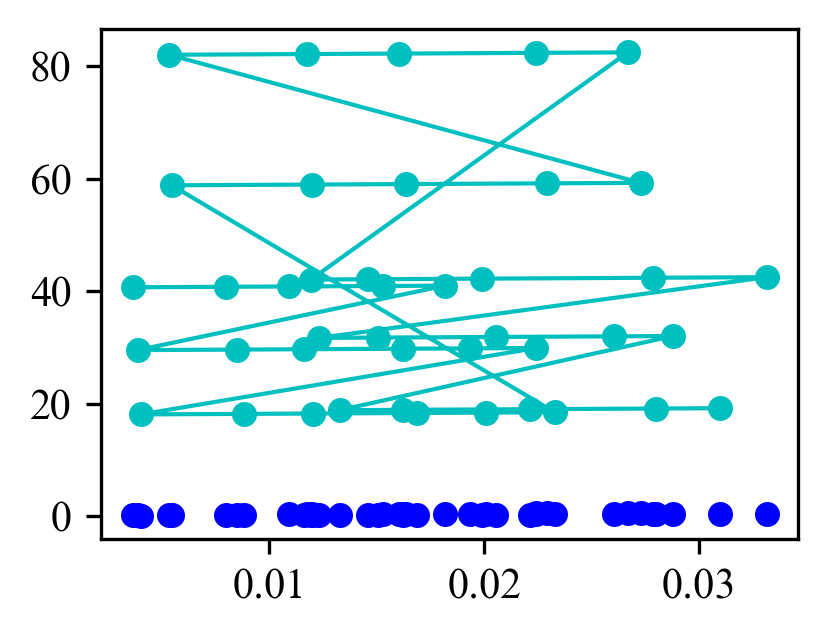

In [ ]:
# Minimize our function using scipy.optimize.minimize

PreParaguess = [20,0,10]
# tanTheta_predict = PreParaguess[0]* ((La/Lb) + 1) * (PreParaguess[1] * preload/(E*b*t) + PreParaguess[2] * (t/La)**2)
tanTheta_predict = (PreParaguess[0]*(Lb/b)*t**0.5*((La/Lb) + 1)) * (4*PreParaguess[1]*preload/(E*b*t) + PreParaguess[2] * (t*t/Lb/Lb))

plt.plot(preload/(E*b*t), np.tan(tipAngle), color='b', marker="o", linewidth=0)
plt.plot(preload/(E*b*t), tanTheta_predict, color='c', marker="o", linewidth=1)

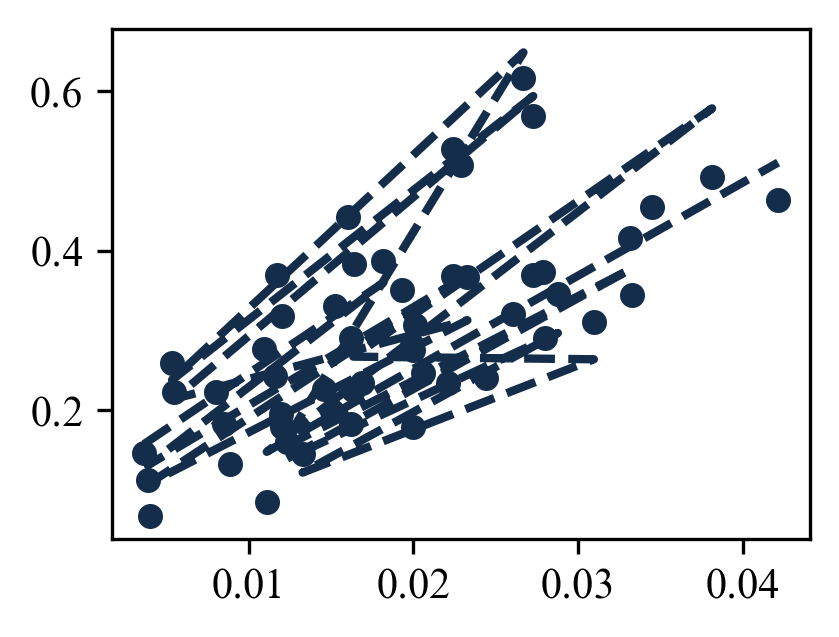

In [ ]:
PreParaguess = [10,50,10]
res = minimize(TwistFitFunction, PreParaguess, data[0:26], method='Nelder-Mead', tol=1e-20)

Afit = res.x[0]
Bfit = res.x[1]
Cfit = res.x[2]

# Predict 
# tanTheta_predict = Afit* ((La/Lb) + 1) * (Bfit * preload/(E*b*t) + Cfit * (t/La)**2)
tanTheta_predict = (Afit*(Lb/b)*t**0.5*((La/Lb) + 1)) * (4*Bfit*preload/(E*b*t) + Cfit * (t*t/Lb/Lb))

# Experiment
tanTheta_real = np.tan(tipAngle)
preload_norm = preload/(E*b*t)

plt.plot(preload_norm, tanTheta_real , color=dblue, marker="o", linewidth=0, alpha=1)
plt.plot(preload_norm, tanTheta_predict, color=dblue, marker=None, linewidth=2, linestyle = 'dashed',alpha=1)

In [ ]:
print(Afit, Bfit, Cfit)

0.006072226199325116 178.48391827899297 1.6979144081346462


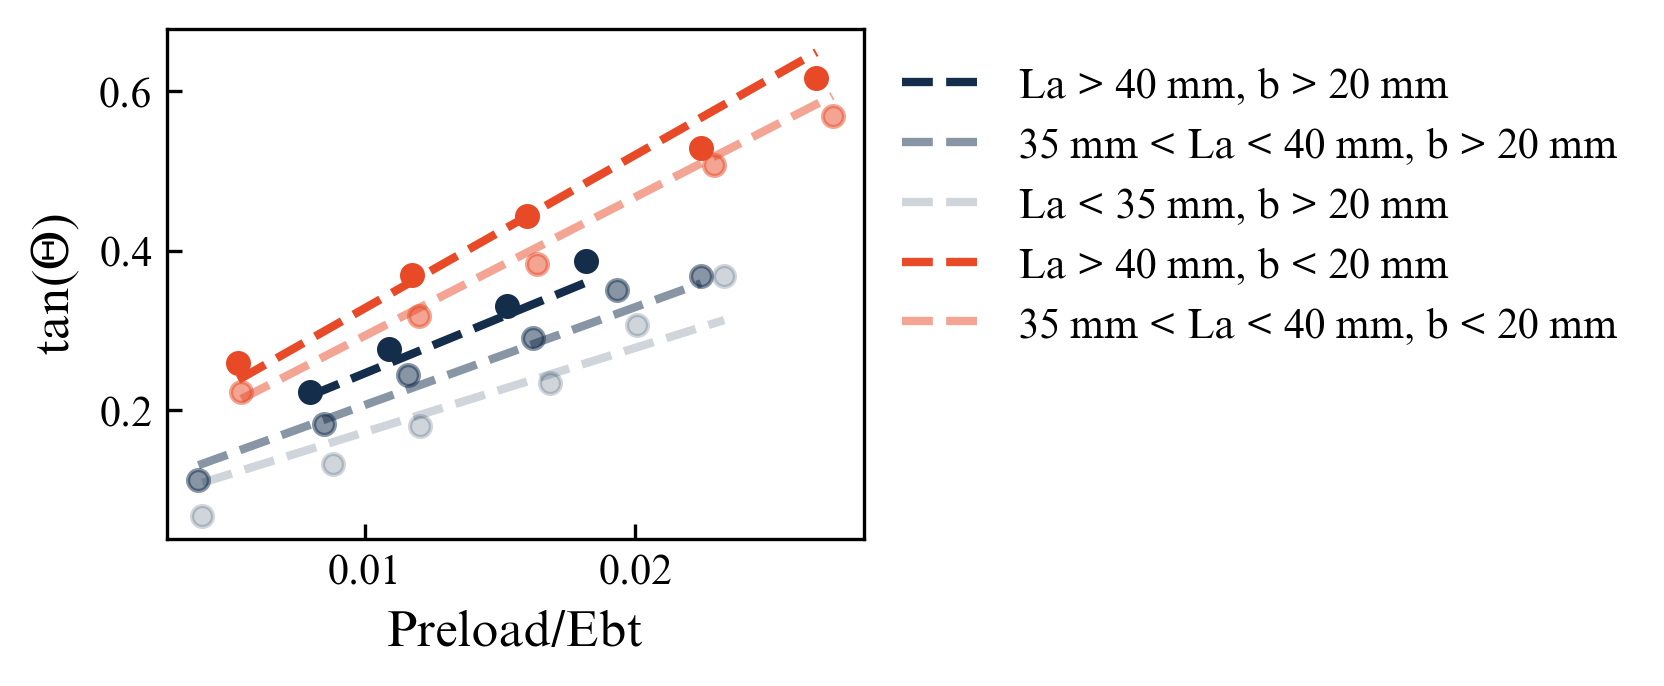

In [ ]:
tempxline = []
tempyline = []
tempi = 0
for i in set(Sample10to1) & set(longchunk) & set(largewidth) & set(largethickness):
  plt.plot(preload_norm[i], tanTheta_real[i] , color=dblue, marker="o", linewidth=0, alpha=1)
  if tempi != i-1:
    tempxline.append(None)
    tempyline.append(None)
  tempxline.append(preload_norm[i])
  tempyline.append(tanTheta_predict[i])
  tempi = i
plt.plot(tempxline, tempyline, color=dblue, marker=None, linewidth=2, linestyle = 'dashed',alpha=1, label = 'La > 40 mm, b > 20 mm ')

tempxline = []
tempyline = []
tempi = 0
for i in set(Sample10to1) & set(middlechunk) & set(largewidth) & set(largethickness):
  plt.plot(preload_norm[i], tanTheta_real[i] , color=dblue, marker="o", linewidth=0, alpha=0.5)
  if tempi != i-1:
    tempxline.append(None)
    tempyline.append(None)
  tempxline.append(preload_norm[i])
  tempyline.append(tanTheta_predict[i])
  tempi = i
plt.plot(tempxline, tempyline, color=dblue, marker=None, linewidth=2, linestyle = 'dashed',alpha=0.5, label = '35 mm < La < 40 mm, b > 20 mm')

tempxline = []
tempyline = []
tempi = 0
for i in set(Sample10to1) & set(shortchunk) & set(largewidth) & set(largethickness):
  plt.plot(preload_norm[i], tanTheta_real[i] , color=dblue, marker="o", linewidth=0, alpha=0.2)
  if tempi != i-1:
    tempxline.append(None)
    tempyline.append(None)
  tempxline.append(preload_norm[i])
  tempyline.append(tanTheta_predict[i])
  tempi = i
plt.plot(tempxline, tempyline, color=dblue, marker=None, linewidth=2, linestyle = 'dashed',alpha=0.2, label = 'La < 35 mm, b > 20 mm')

tempxline = []
tempyline = []
tempi = 0
for i in set(Sample10to1) & set(longchunk) & set(smallwidth) & set(largethickness):
  plt.plot(preload_norm[i], tanTheta_real[i] , color=orange, marker="o", linewidth=0, alpha=1)
  if tempi != i-1:
    tempxline.append(None)
    tempyline.append(None)
  tempxline.append(preload_norm[i])
  tempyline.append(tanTheta_predict[i])
  tempi = i
plt.plot(tempxline, tempyline, color=orange, marker=None, linewidth=2, linestyle = 'dashed',alpha=1, label = 'La > 40 mm, b < 20 mm')

tempxline = []
tempyline = []
tempi = 0
for i in set(Sample10to1) & set(middlechunk) & set(smallwidth) & set(largethickness):
  plt.plot(preload_norm[i], tanTheta_real[i] , color=orange, marker="o", linewidth=0, alpha=0.5)
  if tempi != i-1:
    tempxline.append(None)
    tempyline.append(None)
  tempxline.append(preload_norm[i])
  tempyline.append(tanTheta_predict[i])
  tempi = i
plt.plot(tempxline, tempyline, color=orange, marker=None, linewidth=2, linestyle = 'dashed',alpha=0.5, label = '35 mm < La < 40 mm, b < 20 mm')

tempxline = []
tempyline = []
tempi = 0
for i in set(Sample10to1) & set(shortchunk) & set(smallwidth) & set(largethickness):
  plt.plot(preload_norm[i], tanTheta_real[i] , color=orange, marker="o", linewidth=0, alpha=0.2)
  if tempi != i-1:
    tempxline.append(None)
    tempyline.append(None)
  tempxline.append(preload_norm[i])
  tempyline.append(tanTheta_predict[i])
  tempi = i
plt.plot(tempxline, tempyline, color=orange, marker=None, linewidth=2, linestyle = 'dashed',alpha=0.2)


plt.xlabel("Preload/Ebt")
plt.ylabel("tan($\Theta$)")
plt.tick_params(direction="in") 
plt.legend(bbox_to_anchor=(1, 1), frameon = False)

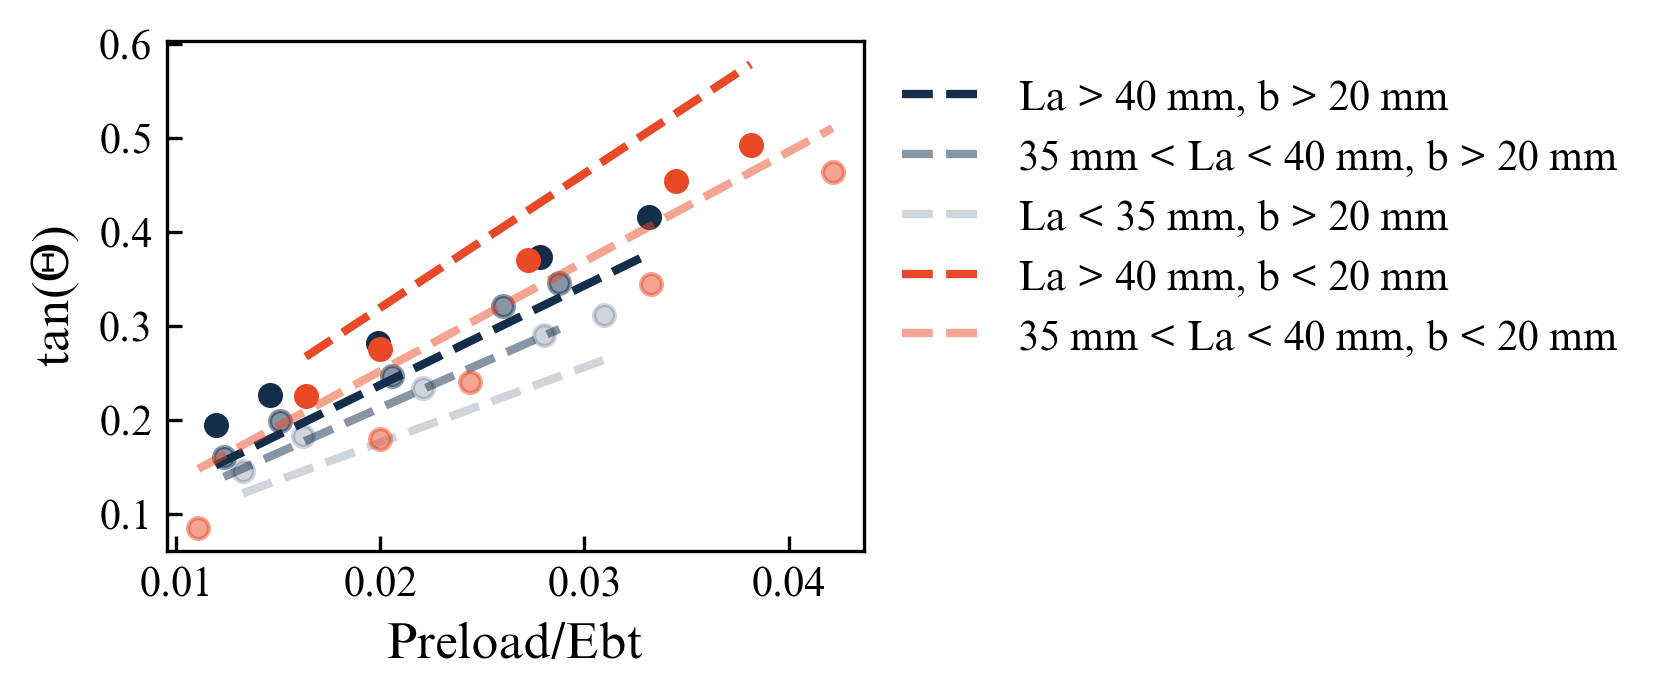

In [ ]:
tempxline = []
tempyline = []
tempi = 0
for i in set(Sample10to1) & set(longchunk) & set(largewidth) & set(smallthickness):
  plt.plot(preload_norm[i], tanTheta_real[i] , color=dblue, marker="o", linewidth=0, alpha=1)
  if tempi != i-1:
    tempxline.append(None)
    tempyline.append(None)
  tempxline.append(preload_norm[i])
  tempyline.append(tanTheta_predict[i])
  tempi = i
plt.plot(tempxline, tempyline, color=dblue, marker=None, linewidth=2, linestyle = 'dashed',alpha=1, label = 'La > 40 mm, b > 20 mm ')

tempxline = []
tempyline = []
tempi = 0
for i in set(Sample10to1) & set(middlechunk) & set(largewidth) & set(smallthickness):
  plt.plot(preload_norm[i], tanTheta_real[i] , color=dblue, marker="o", linewidth=0, alpha=0.5)
  if tempi != i-1:
    tempxline.append(None)
    tempyline.append(None)
  tempxline.append(preload_norm[i])
  tempyline.append(tanTheta_predict[i])
  tempi = i
plt.plot(tempxline, tempyline, color=dblue, marker=None, linewidth=2, linestyle = 'dashed',alpha=0.5, label = '35 mm < La < 40 mm, b > 20 mm')

tempxline = []
tempyline = []
tempi = 0
for i in set(Sample10to1) & set(shortchunk) & set(largewidth) & set(smallthickness):
  plt.plot(preload_norm[i], tanTheta_real[i] , color=dblue, marker="o", linewidth=0, alpha=0.2)
  if tempi != i-1:
    tempxline.append(None)
    tempyline.append(None)
  tempxline.append(preload_norm[i])
  tempyline.append(tanTheta_predict[i])
  tempi = i
plt.plot(tempxline, tempyline, color=dblue, marker=None, linewidth=2, linestyle = 'dashed',alpha=0.2, label = 'La < 35 mm, b > 20 mm')

tempxline = []
tempyline = []
tempi = 0
for i in set(Sample10to1) & set(longchunk) & set(smallwidth) & set(smallthickness):
  plt.plot(preload_norm[i], tanTheta_real[i] , color=orange, marker="o", linewidth=0, alpha=1)
  if tempi != i-1:
    tempxline.append(None)
    tempyline.append(None)
  tempxline.append(preload_norm[i])
  tempyline.append(tanTheta_predict[i])
  tempi = i
plt.plot(tempxline, tempyline, color=orange, marker=None, linewidth=2, linestyle = 'dashed',alpha=1, label = 'La > 40 mm, b < 20 mm')

tempxline = []
tempyline = []
tempi = 0
for i in set(Sample10to1) & set(middlechunk) & set(smallwidth) & set(smallthickness):
  plt.plot(preload_norm[i], tanTheta_real[i] , color=orange, marker="o", linewidth=0, alpha=0.5)
  if tempi != i-1:
    tempxline.append(None)
    tempyline.append(None)
  tempxline.append(preload_norm[i])
  tempyline.append(tanTheta_predict[i])
  tempi = i
plt.plot(tempxline, tempyline, color=orange, marker=None, linewidth=2, linestyle = 'dashed',alpha=0.5, label = '35 mm < La < 40 mm, b < 20 mm')

tempxline = []
tempyline = []
tempi = 0
for i in set(Sample10to1) & set(shortchunk) & set(smallwidth) & set(smallthickness):
  plt.plot(preload_norm[i], tanTheta_real[i] , color=orange, marker="o", linewidth=0, alpha=0.2)
  if tempi != i-1:
    tempxline.append(None)
    tempyline.append(None)
  tempxline.append(preload_norm[i])
  tempyline.append(tanTheta_predict[i])
  tempi = i
plt.plot(tempxline, tempyline, color=orange, marker=None, linewidth=2, linestyle = 'dashed',alpha=0.2)


plt.xlabel("Preload/Ebt")
plt.ylabel("tan($\Theta$)")
plt.tick_params(direction="in") 
plt.legend(bbox_to_anchor=(1, 1), frameon = False)

In [ ]:
set(Sample10to1) & set(shortchunk) & set(largewidth)

{11, 12, 13, 14, 15, 16}

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


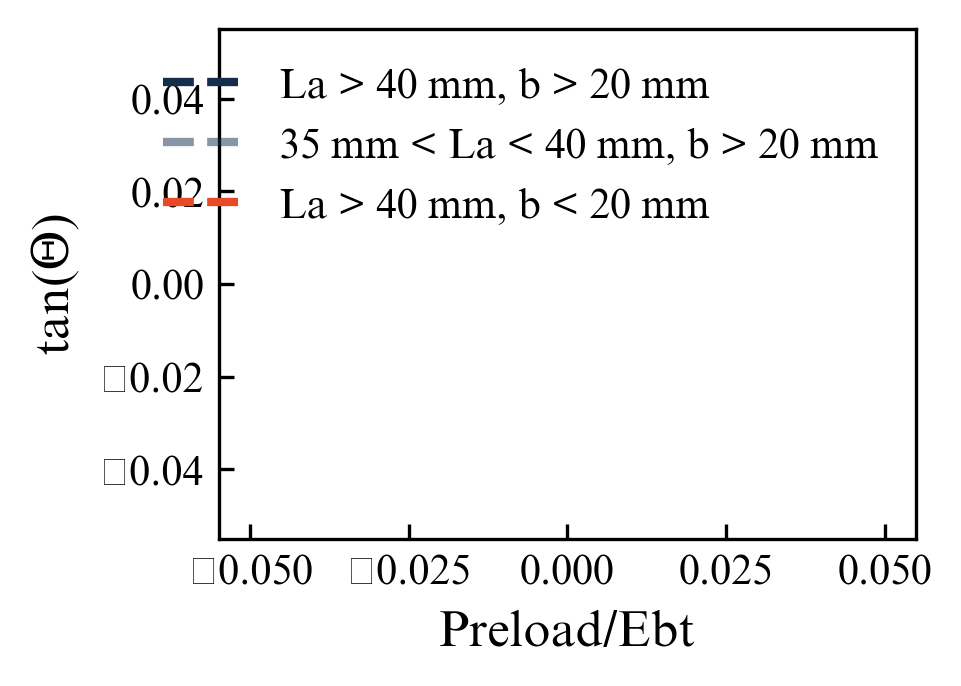

In [ ]:
tempxline = []
tempyline = []
tempi = 0
for i in set(Sample5to1) & set(longchunk) & set(largewidth):
  plt.plot(preload_norm[i], tanTheta_real[i] , color=dblue, marker="o", linewidth=0, alpha=1)
  if tempi != i-1:
    tempxline.append(None)
    tempyline.append(None)
  tempxline.append(preload_norm[i])
  tempyline.append(tanTheta_predict[i])
  tempi = i
plt.plot(tempxline, tempyline, color=dblue, marker=None, linewidth=2, linestyle = 'dashed',alpha=1, label = 'La > 40 mm, b > 20 mm ')

tempxline = []
tempyline = []
tempi = 0
for i in set(Sample5to1) & set(middlechunk) & set(largewidth):
  plt.plot(preload_norm[i], tanTheta_real[i] , color=dblue, marker="o", linewidth=0, alpha=0.5)
  if tempi != i-1:
    tempxline.append(None)
    tempyline.append(None)
  tempxline.append(preload_norm[i])
  tempyline.append(tanTheta_predict[i])
  tempi = i
plt.plot(tempxline, tempyline, color=dblue, marker=None, linewidth=2, linestyle = 'dashed',alpha=0.5, label = '35 mm < La < 40 mm, b > 20 mm')

tempxline = []
tempyline = []
tempi = 0
for i in set(Sample5to1) & set(shortchunk) & set(largewidth):
  plt.plot(preload_norm[i], tanTheta_real[i] , color=dblue, marker="o", linewidth=0, alpha=0.2)
  if tempi != i-1:
    tempxline.append(None)
    tempyline.append(None)
  tempxline.append(preload_norm[i])
  tempyline.append(tanTheta_predict[i])
  tempi = i
plt.plot(tempxline, tempyline, color=dblue, marker=None, linewidth=2, linestyle = 'dashed',alpha=0.2)

tempxline = []
tempyline = []
tempi = 0
for i in set(Sample5to1) & set(longchunk) & set(smallwidth):
  plt.plot(preload_norm[i], tanTheta_real[i] , color=orange, marker="o", linewidth=0, alpha=1)
  if tempi != i-1:
    tempxline.append(None)
    tempyline.append(None)
  tempxline.append(preload_norm[i])
  tempyline.append(tanTheta_predict[i])
  tempi = i
plt.plot(tempxline, tempyline, color=orange, marker=None, linewidth=2, linestyle = 'dashed',alpha=1, label = 'La > 40 mm, b < 20 mm')

tempxline = []
tempyline = []
tempi = 0
for i in set(Sample5to1) & set(middlechunk) & set(smallwidth):
  plt.plot(preload_norm[i], tanTheta_real[i] , color=orange, marker="o", linewidth=0, alpha=0.5)
  if tempi != i-1:
    tempxline.append(None)
    tempyline.append(None)
  tempxline.append(preload_norm[i])
  tempyline.append(tanTheta_predict[i])
  tempi = i
plt.plot(tempxline, tempyline, color=orange, marker=None, linewidth=2, linestyle = 'dashed',alpha=0.5)

tempxline = []
tempyline = []
tempi = 0
for i in set(Sample5to1) & set(shortchunk) & set(smallwidth):
  plt.plot(preload_norm[i], tanTheta_real[i] , color=orange, marker="o", linewidth=0, alpha=0.2)
  if tempi != i-1:
    tempxline.append(None)
    tempyline.append(None)
  tempxline.append(preload_norm[i])
  tempyline.append(tanTheta_predict[i])
  tempi = i
plt.plot(tempxline, tempyline, color=orange, marker=None, linewidth=2, linestyle = 'dashed',alpha=0.2)


plt.xlabel("Preload/Ebt")
plt.ylabel("tan($\Theta$)")
plt.tick_params(direction="in") 
plt.legend(bbox_to_anchor=(1, 1), frameon = False)

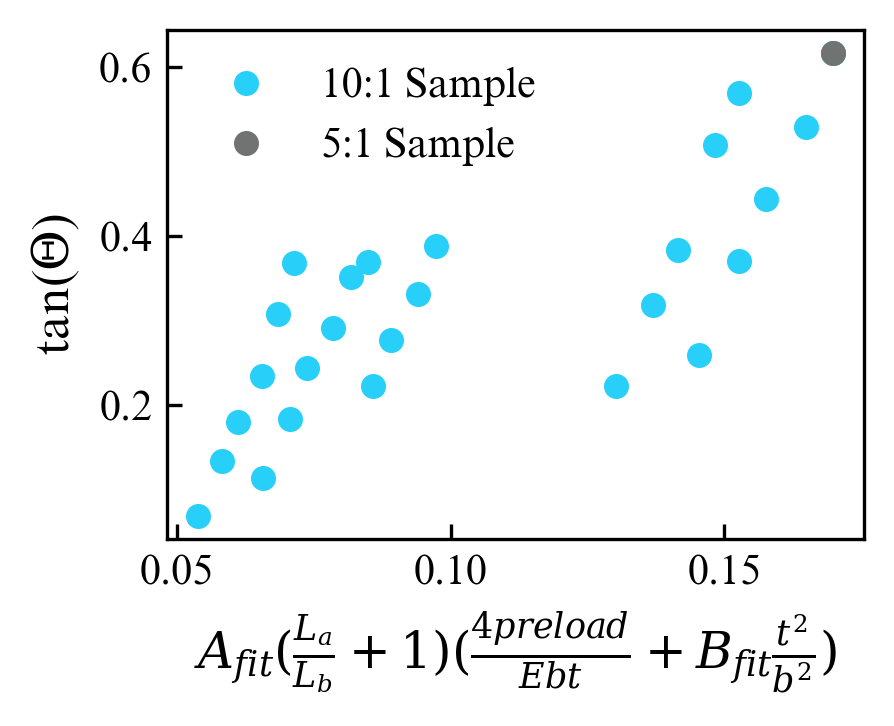

In [ ]:
# plt.plot((Afit*((La/Lb) + 1)) * (4*preload/(E*b*t) + Cfit * (La*t/b/b)), np.tan(tipAngle), color='b', marker="o", linewidth=0)


temptemp = (Afit*((La/Lb) + 1)) * (4*preload/(E*b*t) + Cfit * (t*t/b/b))

for i in set(Sample10to1):
  plt.plot(temptemp[i], tanTheta_real[i] , color=teal, marker="o", linewidth=0, alpha=1)
plt.plot(temptemp[i], tanTheta_real[i] , color=teal, marker="o", linewidth=0, alpha=1, label = '10:1 Sample')
for i in set(Sample5to1):
  plt.plot(temptemp[i], tanTheta_real[i] , color=gray, marker="o", linewidth=0, alpha=1)
plt.plot(temptemp[i], tanTheta_real[i] , color=gray, marker="o", linewidth=0, alpha=1, label = '5:1 Sample')

plt.xlabel(r"$A_{fit}(\frac{L_{a}}{L_b} + 1)(\frac{4preload}{Ebt} + B_{fit}\frac{t^2}{b^2})$")
plt.ylabel("tan($\Theta$)")
plt.tick_params(direction="in") 
plt.legend(frameon = False)